# Fusion Hub Data Quick-Start

This notebook demonstrates the process of:
* Searching a collection to intersect a point location between a start data and end date
* Converting the search result to an `xarray` DataArray
* Subsetting the DataArray to a geometry
* Plotting the time series in a grid
* Extracting data from a point location
* Reducing the data within a geometry
* Downloading a file based on valid data percentage
* Downloading multiple files
* Removing data entries based on some condition
* Creating matplotlib animations

In [1]:
import json
import requests
import pystac
from pystac_client import Client
from pprint import pprint

from botocore.exceptions import ClientError
from shapely.geometry import box, mapping, Point, Polygon
from pyproj.crs import CRS
import pandas as pd
import geopandas as gpd

import xarray as xr
import rioxarray as rxr
import rasterio as rio

from matplotlib import pyplot as plt
import numpy as np

import get_hrrr as hrrr

import os
import base64

ModuleNotFoundError: No module named 'requests'

If you see `ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed`, do not fret, and proceed.

This next cell opens a file `creds.json` which you will need to create in the same directory as the notebook. The format of the file should be:

```
{
"username":"your_username",
"password":"your_password"
}
```

and you have updated with your username and password. 

In [2]:
with open('creds.json') as f:
    creds = json.loads(f.read())
    

This next cell will endecode the `username:password` combination and use it to authorize access to the STAC API given by the `cat_url` endpoint.

In [3]:
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

We'll search for data in the `starfm_predictions_modis_landsat` and `pydms_sharpened_landsat` collections which intersect a point location between a start date and an end date and print out the number of items. 

In [33]:
# Specifiy location and time frame for image download.
site_name = 'ames'
lat = 42
lon = -93.7

geom = {'type': 'Point', 'coordinates': [lon, lat]} 

collections = ["starfm_predictions_modis_landsat", "pydms_sharpened_landsat"]
start_date = "2020-04-01T00:00:00Z"
end_date = "2020-10-01T00:00:00Z"

search = catalog.search(
    collections = collections,
    intersects = geom,
    datetime = [start_date, end_date],
    max_items = 500
)

# items = list(search.items()) # for pystac-client >= 0.4.0
items = list(search.get_all_items()) # for pystac-client < 0.4.0
items.reverse() # make the results ascending in time
len(items)

180

This next cell will determine if the data returned covers more than a single MGRS tile. If there is, choose one of the tiles to subset the list of returned items.

In [34]:
mgrs_tiles = []
for i in items:
    for l in i.to_dict()['links']:
        if 'element84' in l['href']:
            mgrs_tiles.append(l['href'].split(r'/')[-1].split('_')[1])
print(f'number of tiles in query: {len(set(mgrs_tiles))}, {set(mgrs_tiles)}')

# if there is more than one tile, uncomment and execute this next line to choose the MGRS tile you are interested in
# items = [i for i in items if mgrs_tiles[0] in i.id]

number of tiles in query: 1, {'15TVG'}


Now we'll pass the first 25 items to the `FH_Hydrosat` class and stack the items into an `xarray` `DataArray`. We'll print out the DataArray to get a summary of its contents.

In [ ]:
from FH_Hydrosat import FH_Hydrosat
res = FH_Hydrosat(items[:25])
stacked_res = res.stack()
stacked_res.ds.sortby('time')

In [36]:
ds = stacked_res.ds.sortby('time')

The `DataArray` is quite large if we try to access all of the data. For ease of computation, we'll subset the `DataArray` by a polygon, which will be generated by creating a rectangular buffer around the point location by 1km on either side.

In [37]:
p_geom = Point(geom['coordinates'][0], geom['coordinates'][1])
point_df = gpd.GeoDataFrame({'geometry':[p_geom]}, crs=CRS.from_epsg(4326))

In [38]:
raster_crs = CRS.from_wkt(ds.spatial_ref.crs_wkt)
buffer_dist = 1000 # 1km in local UTM zone
poly_df = point_df.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) # square buffer


Let's plot the polygon on a Folium map so we can see where we are extracting the data

In [ ]:
import folium 

# Use WGS 84 (epsg:4326) as the geographic coordinate system
df = gpd.GeoDataFrame(poly_df.to_crs(epsg=4326))

m = folium.Map(location=[p_geom.y, p_geom.x], zoom_start=15, tiles='CartoDB positron', control_scale=True)

# ---------------------------------
# Use satellite image for base map.
tile = folium.TileLayer(
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr = 'Esri',
    name = 'Esri Satellite',
    overlay = False,
    control = True
    ).add_to(m)
# ---------------------------------

# add the polygon and centroid
for _, r in df.iterrows():
    # Without simplifying the representation of each polygon,
    # the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    sim_geo = r[0].simplify(tolerance=0.001)
    geo_j = gpd.GeoSeries(sim_geo).to_json()
    geo_j = folium.GeoJson(data=geo_j,
                    style_function=lambda x: {'fillColor': 'orange'})

    geo_j.add_to(m)
        
    lat = sim_geo.centroid.y
    lon = sim_geo.centroid.x
    folium.Marker(location=[lat, lon]).add_to(m)
    
m

Now let's clip the dataset with the geometry using `rioxarray`'s `rio` utility package

In [ ]:
from FH_Hydrosat import FH_StackedDataset

# clip the raster dataset and cast to a class with slightly more functions
clipped = FH_StackedDataset(ds.rio.clip(poly_df.geometry))
ds_clip = clipped.ds  #*************** what is this?
ds_clip

Now that we have a smaller `DataArray`, let's plot the contents according to the `time` dimension using `xarray`'s plot utility.

In [41]:
ds_clip.plot(x='x', y='y', col='time', col_wrap=5);

ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 59969952-61382565 failed with response_code=0
ERROR 1: Request for 59828210-61239651 failed with response_code=0
ERROR 1: Request for 61159885-62599917 failed with response_code=0
ERROR 1: _TIFFPartialReadStripArray:Cannot read offset/size for strile around ~184
ERROR 1: _TIFFPartialReadStripArray:Cannot read offset/size for strile around ~184
ERROR 1: _TIFFPartialReadStripArray:Cannot read offset/size for strile around ~184
ERROR 1: _TIFFPartialReadStripArray:Cannot read offset/size for strile around ~184


<IPython.core.display.Javascript object>

## Plot a time series for the point location

With the same `DataArray`, we can extract the pixel values which intersect a point location. Let's use the same point location we used to search the STAC catalog and plot it.

In [ ]:
centroid = poly_df.geometry[0].centroid
set_x, set_y, pixtype = (centroid.x, centroid.y, 'Center Pixel') # change 'Center Pixel' for plot title

ax = ds_clip.plot(x='x', y='y', col='time', col_wrap=5)
ax.set_xlabels('Easting [m]')
ax.set_ylabels('Northing [m]')
# --------------------
ax.map(lambda: plt.plot(set_x, set_y, markersize=20, marker=".", color="m"))
# --------------------

# --------------------
plt.show()
plt.savefig('multi-image.png', bbox_inches='tight')

ax = ds_clip.isel(band=0).sel(x=set_x, y=set_y, method='nearest', tolerance=20).plot(marker='o', c='m', figsize=(12,7))
plt.title(f'time series for {pixtype} pixel')
plt.grid(True)
plt.ylabel('Fused LST [K]')
plt.xticks(rotation=45)
plt.show()
plt.savefig('time-series.png', bbox_inches='tight')

Similarly, we can reduce the area within the subsetting geometry to the mean value, and plot against the time series for the point location.

In [ ]:
ax = ds_clip.plot(x='x', y='y', col='time', col_wrap=5)
ax.set_xlabels('Easting [m]')
ax.set_ylabels('Northing [m]')
ax.map(lambda: plt.plot(set_x, set_y, markersize=20, marker=".", color="m"))
plt.show()


ax = ds_clip.isel(band=0).sel(x=set_x, y=set_y, method='nearest', tolerance=20).plot(linestyle='--', marker='o', c='m', label='Point location', figsize=(12,7))
ax = ds_clip.isel(band=0).mean(dim=('x', 'y')).plot(linestyle='--', marker='o', c='b', label='Area mean')
plt.title(f'time series for {pixtype} pixel')
plt.legend()
plt.grid(True)
plt.ylabel('Fused LST [K]')
plt.xticks(rotation=45)
plt.show()

## download a single file

In [44]:
# find which file has the most data in it
max_data_idx = np.argmax(ds_clip.count(dim=('x', 'y', 'band')).values)

outfile = f'./{os.path.basename(res.item_desc[max_data_idx])}'
print(outfile, os.path.exists(outfile))

res.download_single_asset(max_data_idx)

print(outfile, os.path.exists(outfile))

./sharpened_15TVG_hires_lst_mosaic_screened_LC08_20200405_with_S2_15TVG_median_composite_20200405_screened.tif False
./sharpened_15TVG_hires_lst_mosaic_screened_LC08_20200405_with_S2_15TVG_median_composite_20200405_screened.tif True


## download multiple files, since there a few scenes that have full coverage for the AOI

In [ ]:
# download the items above which correspond to items 2,5,6, and 10
# using the download_multiple_assets() function
res.download_multiple_assets([2,5,6,10])

## make an animation from the full set of data

If you see `Javascript Error: IPython is not defined` or `MovieWriter ffmpeg unavailable; using Pillow instead`, do not fret, and proceed.

In [17]:
from IPython.display import HTML

# switch plotting to allow for animations
%matplotlib notebook 

In [ ]:
# use the create_animation() function.
# display the animation with HTML display

ani = clipped.create_animation(save_ani=True, vmin=300, vmax=350)
HTML(ani.to_jshtml())


### drop files with data less than 50% coverage
Sometimes the data will have low coverage due to cloud cover or invalid pixels in the input data products. Let's remove them from the dataset using the `remove_below_data_perc()` function, plot them, and create an animation.

In [ ]:
# to switch back and allow xarray plots
%matplotlib inline 

more_data = FH_StackedDataset(clipped.remove_below_data_perc(clipped.ds, 0.5))
ax = more_data.ds.plot(x='x', y='y', col='time', col_wrap=5)
ax.set_xlabels('Easting [m]')
ax.set_ylabels('Northing [m]')
#plt.show()
clipped
more_data

### Now we will plot the time series using the filtered dataset. Filtered means each tile has atleast 50% valid pixels.

In [ ]:
# Tyler's
# Plot time series with the filter applied to the dataset.

# Filtered LST data
LST_filtered_ds = more_data.ds

# Get hrrr data for plotting with lst.
temp_2m_ds = hrrr.get_hrrr_point_data(lat, lon, start_date, 29)

ax = LST_filtered_ds.isel(band=0).sel(x=set_x, y=set_y, method='nearest', tolerance=20).plot(label='LST', marker='o', c='m', figsize=(12,7))
ax = temp_2m_ds.t2m.plot(label='2mT')

plt.title(f'Fused LST and 2m HRRR Temperature {pixtype} pixel')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()


### Next step is to calculate CATD.  We are going to create a datframe that will contain LST, air temp, and CATD.
1. Create a dataframe for LST from the LST dataset.
2. Get HRRR 2mT data and put it into a dataframe.
3. Merge the two dataframes so we have everything in on df.
4. Calculate CATD using the LST and 2mT df columns and create a new CATD column.

<Axes: xlabel='date'>

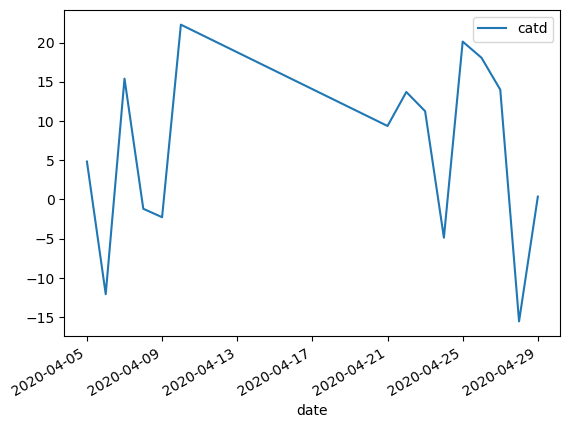

In [129]:
# Tyler's
# Plot CATD time series (LST - 2mT)

# Get a dataset of point LST and convert to dataframe for easier use.
point_LST_ds = LST_filtered_ds.isel(band=0).sel(x=set_x, y=set_y, method='nearest', tolerance=20)
point_lst_df = point_LST_ds.to_dataframe(name='fused_lst')
# Cleanup the df and drop uneeded columns.
point_lst_df.reset_index(inplace=True)
point_lst_df.drop('spatial_ref', axis=1, inplace=True)
# We need to be sure that our date and time formats are consistent.
# Further, some of the fusion products have varying time.  Most are
# 00z but some are something close to that but we need to the times
# of the 2mT and LST to match so we can merge properly.  We'll convert to 
# just date and not worry about the cases where the time is not quite 00z.
point_lst_df['date'] = pd.to_datetime(point_lst_df['time'].dt.date)

# Get a dataset of point hrrr and convert to dataframe for easier use.
temp_2m_df = temp_2m_ds.to_dataframe()
# Clean up df and drop uneeded columns.
drop_cols = ['point', 'metpy_crs', 'gribfile_projection', 'y', 'x']
temp_2m_df.reset_index(inplace=True)
temp_2m_df.drop(drop_cols, axis=1, inplace=True)
temp_2m_df['date'] = pd.to_datetime(temp_2m_df['time'].dt.date)

#print (point_lst_df, temp_2m_df)

# Merge dataframes into one.
lst_2mT_df = point_lst_df.merge(temp_2m_df, how='inner', on='date')
lst_2mT_df

# Calculate CATD (LST - 2mT) and stick into a new column.
lst_2mT_df['catd'] = lst_2mT_df.fused_lst - lst_2mT_df.t2m
lst_2mT_df.reset_index()
#lst_2mT_df['date'] = pd.to_datetime(lst_2mT_df['time'].dt.date)
masked = lst_2mT_df['fused_lst'] > 243

lst_2mT_df[masked].plot(kind = 'line', x = 'date', y = 'catd')



In [ ]:
 # switch back to allow animation
%matplotlib notebook
ani = more_data.create_animation(save_ani=True, vmin=300, vmax=350, anipath='more_data.gif')
HTML(ani.to_jshtml())

You may notice that the animation plays with the most recent date in the data stack first, and then ascending. To reverse the order to descending from the last date in the dataset, use an `xarray` call to reverse the `time` dimension on the dataset.

In [ ]:
# reverse the order
more_data_rev = FH_StackedDataset(more_data.ds.sortby('time', ascending=False))
ani = more_data_rev.create_animation(save_ani=True, vmin=300, vmax=350, anipath='more_data_rev.gif')
HTML(ani.to_jshtml())